In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import base64
import csv
import os
import seaborn as sns
import numpy as np
from glob import glob
from shutil import copyfile

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('dataset/recipes_df10-23-2017.csv', error_bad_lines=False, encoding='utf-8', sep = '\t')

In [4]:
len(set(df.recipe_id))
df.shape

(308562, 425)

In [5]:
df = df.dropna(axis=0, how='any')
df = df.drop_duplicates(subset = 'recipe_id')
# query recipes that were added less than 1 month
df = df.query('date_x < "2017-09-02"')

In [6]:
df.columns = [c.replace(' ', '_') for c in df.columns]

In [282]:
df['printed_total'] = np.exp(df['printed_per_day'])*df['days_exists']
df['printed_daily'] = df['printed_total']/df['days_exists']
df['log_printed_per_day'] = df['printed_per_day']

In [7]:
ing_cols = [col for col in df.columns if '_ing' in col]
tag_cols = [col for col in df.columns if '_tag' in col]
all_cols = df.columns.values.tolist()
rest_cols = set(all_cols) - set(ing_cols) - set(tag_cols)
#rest_cols

In [8]:
df_with_pics = df[df.has_picture == 'yes'].copy()

In [9]:
id_v = 'recipe_id'
dv   = 'printed_per_day'

In [10]:
df_with_pics[[id_v, dv]].head()

,recipe_id,printed_per_day
2,recipe-3333651495007708,-1.533930
5,recipe-3333561494972170,-1.698233
11,recipe-3321081493152882,-1.159237
17,recipe-3205721477169720,-1.889821
19,recipe-3336321495482842,-0.739978


In [11]:
df_with_pics = df_with_pics.drop_duplicates(subset=[id_v, dv])

In [12]:
print(len(df_with_pics.recipe_id))
print(len(set(df_with_pics.recipe_id)))

182231
182231


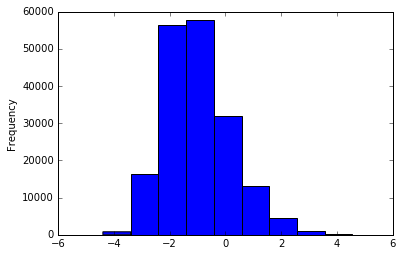

In [13]:
df_with_pics[dv].plot.hist()

In [16]:
df_with_pics['label'] = (df_with_pics[dv] >= df_with_pics[dv].quantile(q=0.5)).astype(str)
df_with_pics['label'].head()

2     False
5     False
11    False
17    False
19     True
Name: label, dtype: object

In [14]:
np.exp(df[dv].quantile(q=0.5))

0.17522724870774797

In [15]:
np.exp(df_with_pics[dv].quantile(q=0.5))

0.31863354037267089

# Save pictures into folders with category in their names

In [48]:
#current_dir = os.getcwd()
#PROJECT_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PROJECT_DIR  = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PICTURES_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\search_pics'

In [22]:
%cd $PROJECT_DIR
%mkdir classification_with_pics2
%mkdir classification_with_pics2\train
%mkdir classification_with_pics2\valid
%mkdir classification_with_pics2\sample
%mkdir classification_with_pics2\results
%mkdir classification_with_pics2\sample\train
%mkdir classification_with_pics2\sample\valid
%mkdir classification_with_pics2\sample\results

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [23]:
# Set pics folder as a working diretory
%cd $PICTURES_DIR

C:\Users\Natalia\Documents\GitHub\search_pics


In [25]:
g = glob('*.jpg')
g[:5]

['recipe-12972895612.jpg',
 'recipe-13972907778.jpg',
 'recipe-14972908306.jpg',
 'recipe-15972985893.jpg',
 'recipe-19972999410.jpg']

In [34]:
# made a renamed copy of pictures
# remove images without labels
nl = (set(g) - set(df_with_pics[id_v]+'.jpg'))
g = list(set(g) - set(nl))
for i in range(len(g)): copyfile(g[i], 
                                 PROJECT_DIR
                                 + "\\classification_with_pics2\\train\\" 
                                 + df_with_pics[df_with_pics[id_v]+'.jpg' == g[i]].label.item() + '.' + g[i])

In [29]:
df_with_pics[df_with_pics[id_v]+'.jpg' == g[1]].label.item() + '.' + g[1]

'False.recipe-35974791166.jpg'

In [35]:
# Set train data folder as a working diretory
%cd $PROJECT_DIR\classification_with_pics2\train\

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train


In [36]:
# move 30k pictures from training set to validation set
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(30000): os.rename(shuf[i]
for i in range(4): os.rename(shuf[i], 
                             PROJECT_DIR
                             + "\\classification_with_pics2\\valid\\"
                             + shuf[i])

In [37]:
# copy 200 images to sample set for experimentation
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(200): copyfile(shuf[i], 
for i in range(5): copyfile(shuf[i],
                            PROJECT_DIR
                            +'\\classification_with_pics2\\sample\\train\\'
                            + shuf[i])

In [38]:
# Set validation data folder as a working diretory
%cd $PROJECT_DIR\classification_with_pics2\valid\

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid


In [39]:
# copy 50 images from validation set to sample validation
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(50): copyfile(shuf[i], 
for i in range(2): copyfile(shuf[i], 
                            PROJECT_DIR
                            +'\\classification_with_pics2\\sample\\valid\\' 
                            + shuf[i])

# Rearrange image files into their respective directories

In [41]:
CLASSIFICATION_DIR = PROJECT_DIR +'\\classification_with_pics2'

In [42]:
#Divide cat/dog images into separate directories
%cd $CLASSIFICATION_DIR/sample/train
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $CLASSIFICATION_DIR/sample/valid
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $CLASSIFICATION_DIR/valid
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $CLASSIFICATION_DIR/train
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-23973004603.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-30974460077.jpg
        2 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\False.recipe-12972895612.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\False.recipe-35974791166.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\False.recipe-36974792563.jpg
        3 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\valid
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\valid

A duplicate file name exists, or the file
cannot be found.


C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\True.recipe-27973607468.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\True.recipe-32974461094.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\True.recipe-37974793352.jpg
        3 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\False.recipe-7971878818.jpg
        1 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train\True.recipe-13972907778.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train\True.recipe-19972999410.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train\True.recipe-20973000461.jpg
C:

# Finetune the VGG

In [46]:
os.getcwd()

'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences\\classification_with_pics2\\train'

In [50]:
%cd $PROJECT_DIR

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [51]:
#import modules
from utils import *
from vgg16 import Vgg16
from datetime import datetime

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using Theano backend.


In [52]:
#current_dir = os.getcwd()
PROJECT_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
CLASSIFICATION_DIR = PROJECT_DIR +'\\classification_with_pics2'

In [53]:
%cd $CLASSIFICATION_DIR

#Set path to sample/ path if desired
path = CLASSIFICATION_DIR + '\\sample'
#path = CLASSIFICATION_DIR + '\\' + 'sample\\'
results_path=path + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2


In [54]:
#import Vgg16 helper class
vgg = Vgg16()

In [60]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=50
no_of_epochs=5

In [61]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 5 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [62]:
start = datetime.now()
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: {}".format(epoch))
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed {} fit operations".format(no_of_epochs))
end = datetime.now()
total = end - start
print('Time to run the script on CPU is {}'.format(total))

Running epoch: 0
Epoch 1/1
5/5 [==============================] - 4s - loss: 1.4670 - acc: 0.6000 - val_loss: 6.7043 - val_acc: 0.0000e+00
Running epoch: 1
Epoch 1/1
5/5 [==============================] - 4s - loss: 0.4488 - acc: 0.6000 - val_loss: 4.1174 - val_acc: 0.5000
Running epoch: 2
Epoch 1/1
5/5 [==============================] - 4s - loss: 8.8492e-04 - acc: 1.0000 - val_loss: 3.2224 - val_acc: 0.5000
Running epoch: 3
Epoch 1/1
5/5 [==============================] - 3s - loss: 4.3636e-04 - acc: 1.0000 - val_loss: 2.6548 - val_acc: 0.5000
Running epoch: 4
Epoch 1/1
5/5 [==============================] - 4s - loss: 0.0015 - acc: 1.0000 - val_loss: 2.4064 - val_acc: 0.5000
Completed 5 fit operations
Time to run the script on CPU is 0:00:38.567853
